## PortfolioCrossSection.ipynb

Code for the Chicago Booth course on Quantitative Portfolio Management by Ralph S.J. Koijen and (current and former) teaching assistants Sangmin Oh, Federico Mainardi, and Laurenz de Rosa.

### Preliminaries

This code builds cross-sectional portfolio strategies and produces relevant analytics.
- As always, the data can be found in the dropbox folder: https://www.dropbox.com/scl/fo/ze2tut4prlptuyhuyofx4/AI7wV4q-6e-KDBSnRhyJptI?rlkey=93yaxhwrk0w8drx5d7o71cvow&dl=0. 
- Please download the file `MasterData_small.parquet`. 

In [115]:
import qpm_download
import qpm
import pandas as pd
import numpy as np
import wrds
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We now choose whether to import data directly from WRDS (`import_data` = True) or to load data from dropbpx (`import_data` = False). If you choose to load data from dropbox, make sure to define the data directoy (`_DATA_DIR`). Also, define a directory where you'd like to store the strategy returns (`_STRATEGY_DIR`). In future versions, we'll update the week. This means we'll be loading larger data sets. But we start with the file size needed only for size and value strategies.

In [116]:
import_data = False                # <-- Edit this line
_DATA_DIR = '../Data'           # <-- Edit this line
_STRATEGY_DIR = '../Strategy'   # <-- Edit this line

Next, we specify the strategy settings.
- First, we select the strategy name. At this point, we have `Value` and `Size`. We'll add more later.
- We can sort every month (`Monthly`) or only in June (`June`). As accounting data mostly comes out quarterly or annually, sorting once a year is often sufficient. As most companies have their fiscal year end in December, and we wait six months to make sure the data are available to investors, we sort in June.
- We can set `_REMOVE_MICRO_CAPS` to either `False` or `True`. If `True`, then we drop the smallest stocks. 
- The next two lines select the sample. 
- The final line selects the number of portfolios. We typically set this to 5 or 10.

In [117]:
_STRATEGY_NAME = 'Value'      
_SORT_FREQUENCY = 'June'        # Either "Monthly" or "June"

_REMOVE_MICRO_CAPS = False      # Either "True" or "False"
_SAMPLE_START = '2001-01-01'    # For ESG data: '2014-01-01'
_SAMPLE_END = '2007-09-30'
_NUM_PORT = 5

### Step 1. Construct Signal

Let's first see which variables are available in the data:

In [118]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'gvkey', 'conm', 'cusip', 'lpermco']

Prices and Returns:
['ret', 'retx', 'prc', 'prcc_c', 'prcc_f', 'vwretd', 'ewretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['aco', 'act', 'ajex', 'am', 'ao', 'ap', 'at', 'capx', 'che', 'cogs', 'csho', 'cshrc', 'dcpstk', 'dcvt', 'dlc', 'dlcch', 'dltis', 'dltr', 'dltt', 'dm', 'dp', 'drc', 'drlt', 'dv', 'dvc', 'dvp', 'dvpa', 'dvpd', 'dvpsx_c', 'dvt', 'ebit', 'ebitda', 'emp', 'epspi', 'epspx', 'fatb', 'fatl', 'ffo', 'fincf', 'fopt', 'gdwl', 'gdwlia', 'gdwlip', 'gwo', 'ib', 'ibcom', 'intan', 'invt', 'ivao', 'ivncf', 'ivst', 'lco', 'lct', 'lo', 'lt', 'mib', 'msa', 'ni', 'nopi', 'oancf', 'ob', 'oiadp', 'oibdp', 'pi', 'ppenb', 'ppegt', 'ppenls', 'ppent', 'prstkc', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'rect', 'recta', 'revt', 'sale', 'scstkc', 'seq', 'spi', 'sstk', 'tstkp', 'txdb', 'txdi', 'txditc', 'txfo', 'txfed', 'txp', 'txt', 'wcap', 'wcapch', 'xacc', 'xad', 'xint

We will work initially with a smaller data set `MasterData_small.parquet`, which is less demanding in terms of your computer's memory.

In [119]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'conm']

Prices and Returns:
['ret', 'retx', 'prc', 'vwretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['at', 'cogs', 'revt', 'be']

Others:
['vol', 'me', 'ESG_score', 'E_score', 'S_score', 'G_score', 'carbon_intensity']



#### Load Data

Different strategies used different signals and different signals are based on different fundamentals. Thus, we first construct the list of fundamentals that we need to download or to load from Dropbox given the strategy that we specified in `_STRATEGY_NAME`.

In [120]:
signal_variables = qpm.return_signal(_STRATEGY_NAME)

Given the list of fundamentals needed to construct the strategy in `_STRAGEY_NAME`, we proceed to download the data or to load the data from Dropbox.

In [121]:
if import_data == True:

    df_full = qpm_download.cross_section_compact(_SAMPLE_START, _SAMPLE_END, _STRATEGY_NAME, signal_variables)
    
if import_data == False:
    
    df_full = qpm.load_data(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet', variable_list = signal_variables)

> Loading Raw Data...
> Renaming key variables...
> Dropping duplicates...
> Creating Auxiliary Variables...


#### Plot Key Variables

In [122]:
df_full.columns

Index(['daret', 'conm', 'cma', 'shrout', 'rmw', 'permno', 'retx', 'smb', 'be',
       'hml', 'prc', 'revt', 'rf', 'vol', 'umd', 'mktrf', 'cogs', 'exchcd',
       'ticker', 'ldate', 'at', 'me', 'shrcd', 'profitA', 'ldate_lag',
       'screen', 'ldate_lag12', 'screen12', 'me_lagged'],
      dtype='object')

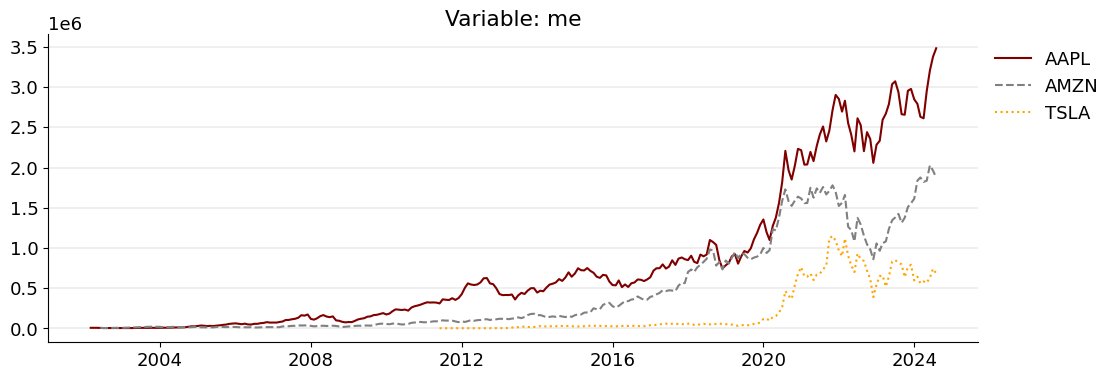

In [123]:
qpm.plot_variables(df_full, variable_list = ['me'],  id_type = 'ticker', id_list = ['AAPL', 'AMZN', 'TSLA'],
                     start_date = '1999-01-01', end_date = '2024-08-31')

#### Construct Signal

In [124]:
if _STRATEGY_NAME == 'Size':

	df_full['signal'] = -df_full['me']
	
elif _STRATEGY_NAME == 'Value':

	df_full['signal'] = df_full['be'] / df_full['me']
        
else:
	
	raise Exception('Please provide a valid _STRATEGY_NAME..')  
    
df_sum = df_full.sort_values(['ldate','ticker'])	
print(df_sum[['ldate','ticker','me','signal']].loc[df_sum['ticker'].isin(['AAPL', 'AMZN', 'TSLA'])].tail(3))    

             ldate ticker            me    signal
127227  2024-09-01   AAPL  3.522211e+06  0.017644
740737  2024-09-01   AMZN  1.958515e+06  0.103076
1134702 2024-09-01   TSLA  8.390474e+05  0.074649


#### Sample Selection

In [125]:
# Lag signal by one period so that the signal value is known at the time of portfolio creation
df_full['signal'] = qpm.create_lag(df_full, var_name = 'signal', lag = 1)

df = qpm.select_sample(df_full, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)

> Selecting Sample for Given Criteria...


### Step 2. Portfolio Construction

In [126]:
df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)
print(df_rets.tail())

> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
        ldate  retP_rank_longonly  retP_rank_longshort  retP_vw_P1  \
69 2007-05-01            0.022018            -0.010324    0.038168   
70 2007-06-01           -0.004773             0.008236   -0.013332   
71 2007-07-01           -0.051456            -0.009726   -0.014317   
72 2007-08-01           -0.014974            -0.017623    0.018110   
73 2007-09-01            0.008599            -0.037887    0.054130   

    retP_vw_P2  retP_vw_P3  retP_vw_P4  retP_vw_P5   retF_vw  
69    0.033380    0.046069    0.038320    0.037462 -0.000707  
70   -0.003539   -0.019395   -0.025987   -0.012011  0.001321  
71   -0.019764   -0.035107   -0.051353   -0.074184 -0.059867  
72    0.011764    0.014487    0.012720   -0.004830 -0.022940  
73    0.043895    0.029635    0.032139    0.014866 -0.039264  


### Step 3. Portfolio Analytics

> Merging strategy returns with Fama and French factor returns...


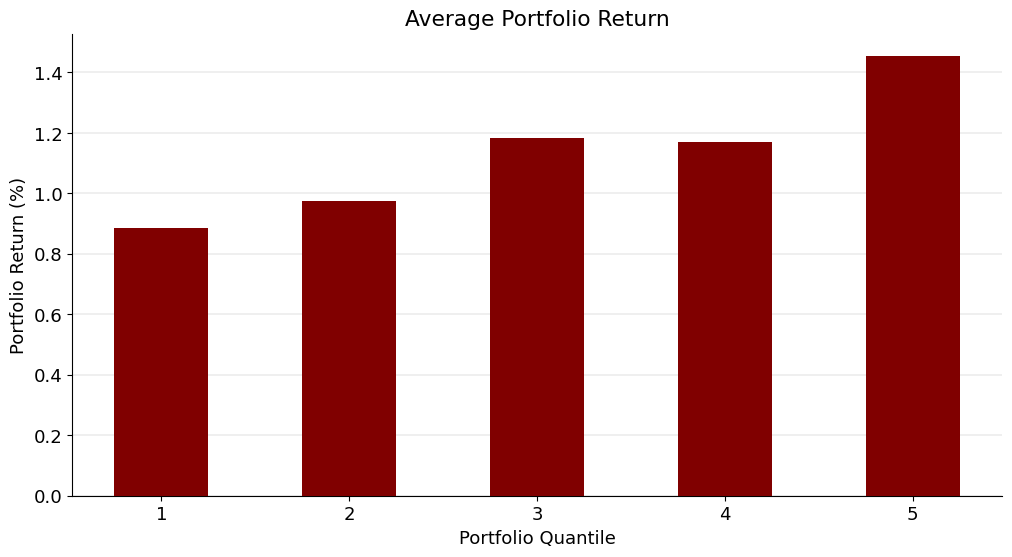

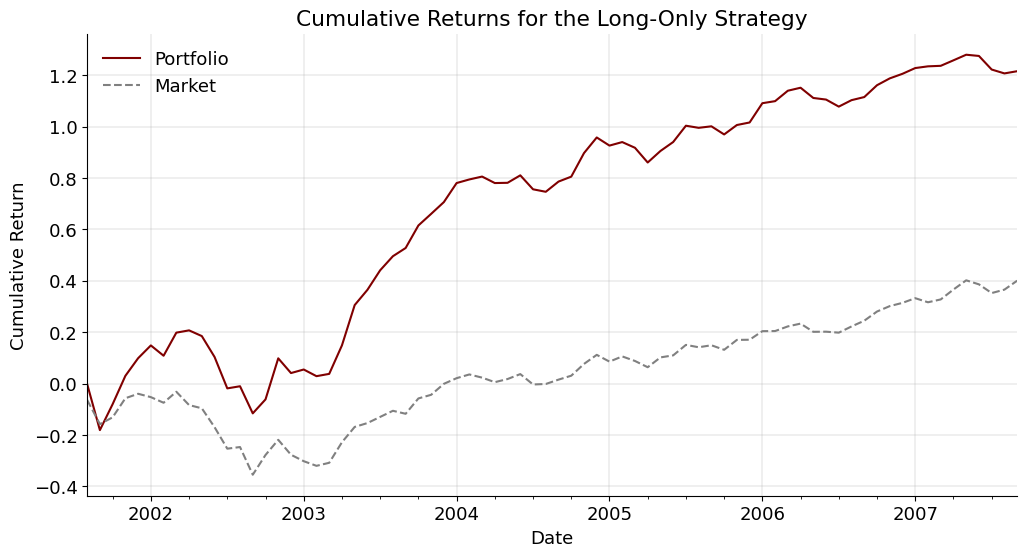

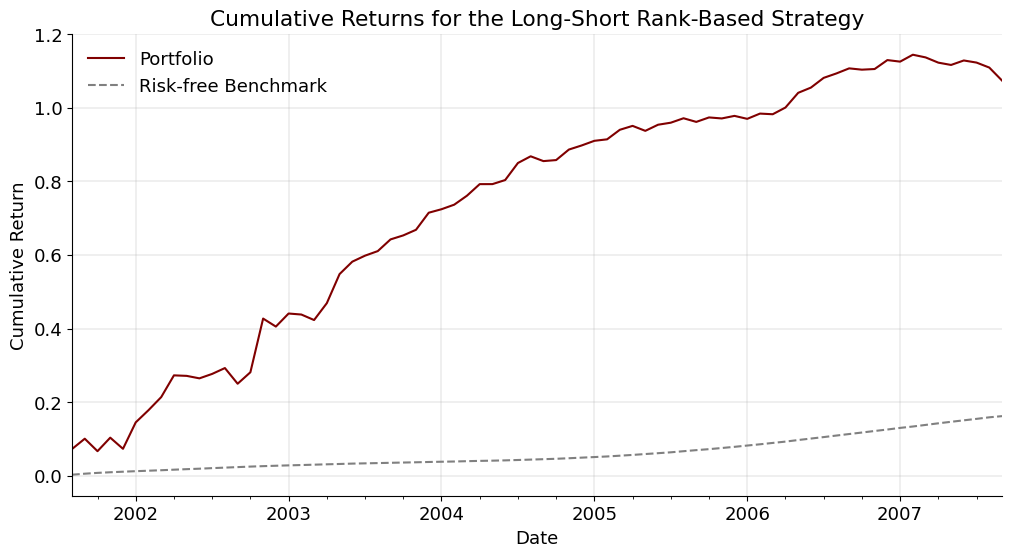

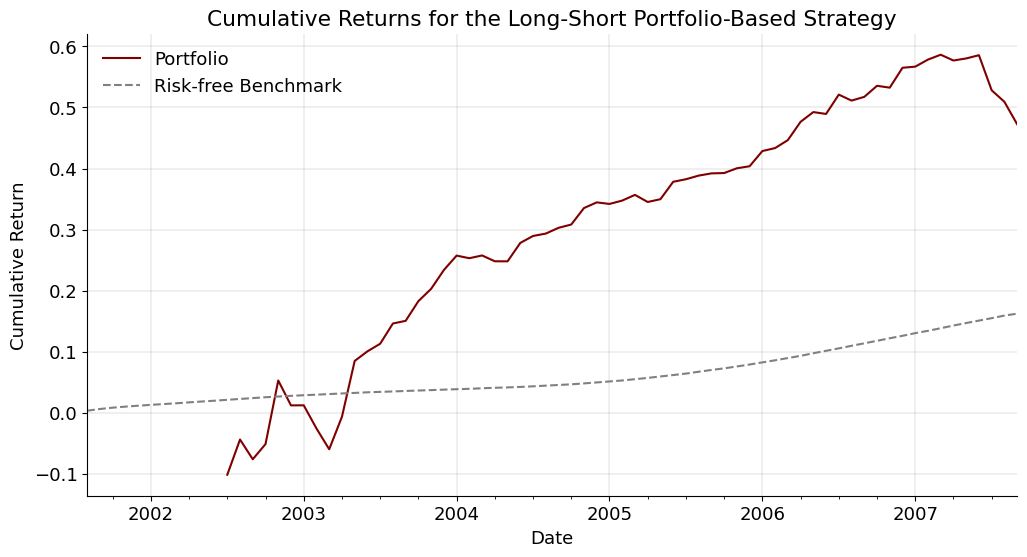

In [127]:
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [128]:
qpm.analyze_strategy(df_rets, analysis_type = 'Summary')

> Merging strategy returns with Fama and French factor returns...
                     count      mean       std       min       25%       50%  \
retP_rank_longonly    74.0  0.018177  0.057513 -0.163967 -0.009262  0.013846   
retP_rank_longshort   74.0  0.012822  0.029697 -0.043060 -0.005744  0.010270   
retF_vw               63.0  0.005707  0.030455 -0.098284 -0.003369  0.003639   
mktrf                 74.0  0.003930  0.037454 -0.103500 -0.018675  0.010050   
smb                   74.0  0.004928  0.026838 -0.064300 -0.010900  0.003000   
hml                   74.0  0.003381  0.019698 -0.076500 -0.006725  0.004050   

                          75%       max  
retP_rank_longonly   0.047095  0.173316  
retP_rank_longshort  0.025259  0.155751  
retF_vw              0.020690  0.108628  
mktrf                0.024325  0.082200  
smb                  0.025400  0.067200  
hml                  0.015850  0.038800  


In [129]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                  (1)       (2)       (3)       (4)       (5)      (6)   
-------------------------------------------------------------------------
const          0.0016    0.0069**  0.0094*** -0.0006   0.0061**  0.0088**
               (0.0031)  (0.0034)  (0.0035)  (0.0024)  (0.0024)  (0.0035)
mktrf          0.5565*** 1.3405*** 0.2233**  0.5443*** 1.1333*** 0.2649**
               (0.0914)  (0.0994)  (0.1023)  (0.0766)  (0.0754)  (0.1110)
hml                                          0.8300*** 0.0765    0.2691  
                                             (0.1437)  (0.1416)  (0.2084)
smb                                          0.1719    0.8301*** -0.1241 
                                             (0.1098)  (0.1081)  (0.1592)
R

In [130]:
if _REMOVE_MICRO_CAPS:
    save_dir = '%s/StrategyReturns_%s_%s_noMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)
else:
    save_dir = '%s/StrategyReturns_%s_%s_withMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)

df_rets.to_csv(save_dir)
print('Saved Strategy Returns to %s' %(save_dir))

Saved Strategy Returns to ../Strategy/StrategyReturns_Value_June_withMicroCaps.csv
